# EoMT Anomaly Head Evaluation

This notebook is designed to validate the **proposed extension** (Anomaly Head) of the EoMT architecture on benchmark datasets. The primary goal is to test the effectiveness of the new architectures in explicitly predicting anomaly scores compared to traditional post-hoc baselines.

### Execution Notes
* **Environment:** Run on **Google Colab** (or Kaggle) with **GPU** acceleration enabled.
* **Storage:** Datasets are downloaded from anexternal google drive folder.

In [1]:
!git clone -b fine-tuning_only_queries https://github.com/Giacomo-FMJ/MaskArchitectureAnomaly

Cloning into 'MaskArchitectureAnomaly'...
remote: Enumerating objects: 1124, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 1124 (delta 188), reused 163 (delta 125), pack-reused 843 (from 3)
Receiving objects: 100% (1124/1124), 43.80 MiB | 19.94 MiB/s, done.
Resolving deltas: 100% (627/627), done.


In [2]:
%cd ./MaskArchitectureAnomaly/eomt

/content/MaskArchitectureAnomaly/eomt


In [3]:
%%capture
!pip install lightning

In [4]:
import os
import csv
import yaml
import gdown
import zipfile
import warnings
import requests
import importlib
from tqdm.auto import tqdm
from typing import Iterable, Any

import numpy as np
import matplotlib.pyplot as plt

from dsets.generic_anomaly import GenericAnomalyDataset
from sklearn.metrics import average_precision_score, roc_curve

import torch
from torchvision import transforms
from torch.nn import functional as F
from torch.amp.autocast_mode import autocast

from lightning import seed_everything
from huggingface_hub import hf_hub_download
from huggingface_hub.utils import RepositoryNotFoundError

In [5]:
def fpr_at_95_tpr(scores, labels):
    """
    Calculates the False Positive Rate (FPR) when the True Positive Rate (TPR) is 95%
    """
    fpr, tpr, thresholds = roc_curve(labels, scores)
    if all(tpr < 0.95):
        return 1.0
    # Find the index where TPR is at least 0.95
    idx = np.argmax(tpr >= 0.95)
    return fpr[idx]

def select_device(device_: str) -> torch.device:

    if device_ == "auto":
        if torch.cuda.is_available():
            return torch.device("cuda")
        elif torch.mps.is_available():
            return torch.device("mps")
        else:
            return torch.device("cpu")

    if device_ == "cpu":
        return torch.device("cpu")
    elif device_ == "cuda" and torch.cuda.is_available():
        return torch.device("cuda")
    elif device_ == "mps" and torch.mps.is_available():
        return torch.device("mps")

    print("[WARNING] Device not found or not available. Using CPU")
    return torch.device("cpu")

def get_chekcpoint():

    """
    Downloads the checkpoint (.ckpt) from Google Drive.

    The function downloads the file from the provided URL using `gdown`
    and saves it locally as 'extension_model.ckpt'
    """

    url = "https://drive.google.com/file/d/1dxkiGWDgjklAY5v0pB0Ybl3YlRZKbGk0/view?usp=drive_link"

    output_filename = "trained_model.ckpt"

    # Scarica solo se non esiste già (opzionale, rimuovi l'if se vuoi sovrascrivere sempre)
    if not os.path.exists(output_filename):
        print(f"Downloading {output_filename}...")
        gdown.download(url, output=output_filename, quiet=False, fuzzy=True)
    else:
        print(f"{output_filename} already exists. Skipping download.")

    return output_filename

def get_eomt_trained_model():
    """
    Downloads the EOMT trained model from the given Google Drive folder link, extracts its contents,
    and performs cleanup and renaming operations if necessary.

    The function checks if the local folder eomt_trained_model exists. If not, it downloads the files
    from the provided URL using the gdown library. After downloading the folder, it looks for a zip
    file within the folder, unzips its contents, and skips files related to macosx. Additionally, if
    the dataset name contains a typo (e.g., "Obsticle"), it renames it to correct the spelling
    (e.g., "Obstacle").

    :raises zipfile.BadZipFile: If the zip file within the folder is corrupted or invalid.
    :raises OSError: If there is an issue accessing or modifying files or directories.
    :return: None
    """

    # folder link
    url = "https://drive.google.com/drive/folders/1q2vHUzora2nP52fP50zmoQAykWuwoGav?usp=share_link"

    folder_name = "eomt_trained_model"

    if not os.path.exists(folder_name):
        gdown.download_folder(url, output=folder_name, quiet=True)

    zip_path = os.path.join(folder_name, "Validation_Dataset.zip")

    with zipfile.ZipFile(zip_path, 'r') as zip_obj:
        for file_name in zip_obj.namelist():
            if "macosx" in file_name.lower():
                continue
            zip_obj.extract(file_name, folder_name)

    # fix a typo in the dataset name
    for dirname in os.listdir(os.path.join(folder_name, "Validation_Dataset")):
        if "obsticle" in dirname.lower():
            os.rename(os.path.join(folder_name, "Validation_Dataset", dirname), os.path.join(folder_name, "Validation_Dataset", dirname.replace("Obsticle", "Obstacle")))

In [6]:
seed_everything(0, verbose=False)

IGNORE_INDEX = 255
device = select_device("auto")
img_idx = 2  # change to the index of the image you want to visualize
config_path = "configs/dinov2/common/eomt_base_640_ext.yaml"
data_path = "raw_datasets"  # dataset directory
anomaly_config_path = "/content/MaskArchitectureAnomaly/eomt/configs/dinov2/common/generic_anomaly.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

def create_mapping(images, ignore_index):
    # Function to visualize cityscapes objects in the target samples
    unique_ids = np.unique(np.concatenate([np.unique(img) for img in images]))
    valid_ids = unique_ids[unique_ids != ignore_index]
    colors = np.array(
        [plt.cm.hsv(i / len(valid_ids))[:3] for i in range(len(valid_ids))]
    )
    mapping = {cid: colors[i] for i, cid in enumerate(valid_ids)}
    mapping[ignore_index] = np.array([0, 0, 0])
    return mapping


In [7]:
warnings.filterwarnings("ignore",message=r".*Attribute 'network' is an instance of `nn\.Module` and is already saved during checkpointing.*")

img_size = (1024,1024)
num_classes = 19

# Load encoder
encoder_cfg = config["model"]["init_args"]["network"]["init_args"]["encoder"]
encoder_module_name, encoder_class_name = encoder_cfg["class_path"].rsplit(".", 1)
encoder_cls = getattr(importlib.import_module(encoder_module_name), encoder_class_name)
encoder = encoder_cls(img_size=img_size, **encoder_cfg.get("init_args", {}))

# Load network
network_cfg = config["model"]["init_args"]["network"]
network_module_name, network_class_name = network_cfg["class_path"].rsplit(".", 1)
network_cls = getattr(importlib.import_module(network_module_name), network_class_name)
network_kwargs = {k: v for k, v in network_cfg["init_args"].items() if k not in ["encoder", "masked_attn_enabled"]}
network = network_cls(
    masked_attn_enabled=False,
    #num_classes=num_classes,
    encoder=encoder,
    **network_kwargs)

# Load Lightning module
lit_module_name, lit_class_name = config["model"]["class_path"].rsplit(".", 1)
lit_cls = getattr(importlib.import_module(lit_module_name), lit_class_name)
model_kwargs = {k: v for k, v in config["model"]["init_args"].items() if k not in ["network","num_classes"]}
if "stuff_classes" in config["data"].get("init_args", {}):
    model_kwargs["stuff_classes"] = config["data"]["init_args"]["stuff_classes"]


model = (
    lit_cls(
        img_size=img_size,
        num_classes=19,
        network=network,
        **model_kwargs).eval().to(device))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

EoMT_EXT: num_classes = 19


Unfreezing anomaly_head params...


In [8]:
def load_pretrained_model(model_,
                          device_,
                          *,
                          config_=None,
                          local_path=None,
                          repo_namespace="tue-mps",
                          hf_filename="pytorch_model.bin",
                          strict=False,
                          map_location=None,
                          ):

    """
    Load a pretrained model with optional configurations and specified parameters.

    This function attempts to load a pretrained model's weights either from a
    local path or from the HuggingFace Hub. If a configuration object with logger
    information is provided, it attempts to locate and download the model from
    the specified HuggingFace repository. If a mismatch in the positional
    embedding shapes between the model and checkpoint is detected, the positional
    embedding in the state dictionary will be ignored. After loading the state
    dictionary, the model is set to evaluation mode and moved to the specified
    device.

    :param model_: The PyTorch model to load the pretrained weights into.
    :param device_: The device to move the model to after loading the weights.
    :param config_: Optional configuration object containing model and logger settings.
    :param local_path: Optional local file path to a pretrained checkpoint.
    :param repo_namespace: Namespace of the HuggingFace Hub repository where the pretrained model is hosted. Defaults to "tue-mps".
    :param hf_filename: Filename of the pretrained model checkpoint in the repository. Defaults to "pytorch_model.bin".
    :param strict: Whether to enforce strict loading of layers into the model. Defaults to False.
    :param map_location: Device mapping location for loading the checkpoint. Defaults to None.
    :return: The model with loaded pretrained weights, set to evaluation mode and moved to the specified device.
    """

    ckpt_path = local_path or None

    if config_:
        name_ = (config_.get("trainer", {})
                .get("logger", {})
                .get("init_args", {})
                .get("name"))

        if name_:
            try:
                ckpt_path = hf_hub_download(
                    repo_id=f"{repo_namespace}/{name_}",
                    filename=hf_filename)
            except RepositoryNotFoundError:
                warnings.warn(f"Pretrained model `{name_}` not found on HuggingFace Hub")
                return model_.eval().to(device_)

    if not ckpt_path:
        warnings.warn("No checkpoint provided or found")
        return model_.eval().to(device_)

    ckpt = torch.load(ckpt_path, map_location=map_location)

    # Lightning .ckpt
    state_dict_ = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt

    # Drop positional embedding if shape mismatches
    for key in ("network.encoder.backbone.pos_embed", "encoder.backbone.pos_embed"):
        if key in state_dict_ and key in model_.state_dict():
            if state_dict_[key].shape != model_.state_dict()[key].shape:
                del state_dict_[key]

    model_.load_state_dict(state_dict_, strict=strict)
    model_.eval().to(device_)
    return model_

In [9]:
get_eomt_trained_model()
check_point = get_chekcpoint()

Downloading...
From (original): https://drive.google.com/uc?id=1dxkiGWDgjklAY5v0pB0Ybl3YlRZKbGk0
From (redirected): https://drive.google.com/uc?id=1dxkiGWDgjklAY5v0pB0Ybl3YlRZKbGk0&confirm=t&uuid=8415324f-ad2a-4616-b257-c361b3a98c63
To: /content/MaskArchitectureAnomaly/eomt/trained_model.ckpt
100%|██████████| 389M/389M [00:07<00:00, 50.9MB/s]


In [10]:
#per usare questa parte, togliere il commento che genera trained_model
model = load_pretrained_model(
    model,
    device,
    local_path=check_point,
    map_location=device,
    strict=False)

In [11]:
# Define datasets_cfg globally
anomaly_config_path = "/content/MaskArchitectureAnomaly/eomt/configs/dinov2/common/generic_anomaly.yaml"
with open(anomaly_config_path, "r") as f:
    anomaly_cfg = yaml.safe_load(f)

datasets_cfg = anomaly_cfg["data"]["init_args"]["datasets"]


def create_color_mapping(images, ignore_index):
    """Creates a consistent color mapping for semantic classes."""
    if isinstance(images, list):
        flat_list = [np.array(img).flatten() for img in images if not isinstance(img, dict)]
        concatenated = np.concatenate(flat_list) if flat_list else np.array([])
    else:
        concatenated = np.array(images).flatten()
    unique_ids = np.unique(concatenated)
    valid_ids = unique_ids[unique_ids != ignore_index]
    colors = np.array([plt.cm.hsv(i / max(1, len(valid_ids)))[:3] for i in range(len(valid_ids))])
    mapping = {cid: colors[i] for i, cid in enumerate(valid_ids)}
    mapping[ignore_index] = np.array([0, 0, 0])
    return mapping

def apply_colormap(image, mapping):
    """Applies the generated color mapping to a 2D mask."""
    if image.ndim > 2: image = image[0]
    colored_image = np.zeros((*image.shape, 3))
    unique_vals = np.unique(image)
    for cid in unique_vals:
        if cid in mapping:
            colored_image[image == cid] = mapping[cid]
        else:
            colored_image[image == cid] = [0, 0, 0]
    return colored_image

# MSP CALCULATION
def compute_msp_anomaly_score(logits):
    """
    Computes the anomaly score based on MSP (1 - Max Confidence).
    Returns a tensor (H, W) with values between 0.0 and 1.0.
    """
    probs = torch.softmax(logits, dim=0)
    if probs.shape[0] == 2:
        return probs[1]
    else:
        max_prob, _ = torch.max(probs, dim=0)
        return 1.0 - max_prob

# VISUALIZATION FUNCTION
def plot_anomaly_results(img_in, pred_mask, anomaly_map, target_np, ignore_index=IGNORE_INDEX):
    """
    Plots the 4-column comparison: Input | Semantic | MSP (Grayscale) | Ground Truth.

    Args:
        img_in (Tensor or Numpy): The input image [C, H, W] or [H, W, C].
        pred_mask (Numpy): Semantic prediction mask [H, W].
        anomaly_map (Numpy): Raw anomaly score map [H, W] (values 0-1).
        target_np (Numpy): Ground truth mask [H, W].
        ignore_index (int): Index to ignore in visualization.
    """

    # 1. Prepare Input Image
    if isinstance(img_in, torch.Tensor):
        img_vis = img_in.permute(1, 2, 0).cpu().float().numpy()
    else:
        img_vis = img_in

    # Normalize if necessary (assuming standard 0-255 or 0-1 range)
    if img_vis.max() > 1.1:
        img_vis /= 255.0
    img_vis = np.clip(img_vis, 0, 1)

    # 2. Prepare Semantic Visualization
    mapping = create_color_mapping([pred_mask], ignore_index)
    vis_semantic = apply_colormap(pred_mask, mapping)

    # 3. Prepare MSP Anomaly Map (Grayscale RGB Style)
    # Replicates the logic: .repeat(3, 1, 1) -> Stack on last axis for Numpy
    # 0.0 (Black) = Normal / High Confidence
    # 1.0 (White) = Anomaly / Low Confidence
    msp_rgb = np.stack([anomaly_map, anomaly_map, anomaly_map], axis=-1)
    msp_rgb = np.clip(msp_rgb, 0, 1)

    # 4. Prepare Ground Truth
    vis_gt = np.zeros_like(target_np, dtype=np.float32)
    vis_gt[target_np == 1] = 1.0        # Anomaly -> White
    vis_gt[target_np == ignore_index] = 0.4 # Ignored -> Gray
    # Background stays 0.0 -> Black

    # 5. Plotting
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))

    items = [
        ("Input Image", img_vis, {}),
        (f"Semantic Prediction\nClasses: {len(np.unique(pred_mask))}", vis_semantic, {}),
        ("MSP Anomaly Score\n(White=Anomaly, Black=Normal)", msp_rgb, {}),
        ("Ground Truth", vis_gt, dict(cmap="gray", vmin=0, vmax=1))]

    for a, (title, img, kw) in zip(ax, items):
        a.imshow(img, **kw)
        a.set_title(title)
        a.set_axis_off()

    fig.tight_layout()
    plt.show()

# INFERENCE PIPELINE
def run_inference_and_plot(model, device_, dataset_cfg, img_idx=15):
    print(f"STARTING INFERENCE (Index: {img_idx})")
    model.eval()

    # 1. Dataset Initialization
    img_size = (1024, 1024)
    ds_conf = dataset_cfg[0] if isinstance(dataset_cfg, list) else dataset_cfg
    ds = GenericAnomalyDataset(ds_conf, img_size=img_size)

    # 2. Data Loading
    sample = ds[img_idx]
    if isinstance(sample, dict):
        img_raw = sample.get('image')
        target = sample.get('label') or sample.get('mask') or sample.get('gt')
        if target is None and len(sample) > 1:
             keys = list(sample.keys())
             if keys[1] != 'image': target = sample[keys[1]]
    else:
        img_raw, target = sample

    # Fix Target Format
    if isinstance(target, dict):
        for k, v in target.items():
            if isinstance(v, (torch.Tensor, np.ndarray)):
                target = v
                break

    if isinstance(target, torch.Tensor): target = target.cpu().numpy()
    if isinstance(target, np.ndarray):
        target_np = target[0].astype(np.uint8) if target.ndim == 3 else target.astype(np.uint8)
    else:
        target_np = np.zeros((1024, 1024), dtype=np.uint8)

    # 3. Prepare Input Tensor
    if not isinstance(img_raw, torch.Tensor):
        img_in = transforms.ToTensor()(img_raw).to(device_)
    else:
        img_in = img_raw.to(device_)

    print("Processing Image...")

    with torch.no_grad(), torch.autocast(device_type=device_.type, dtype=torch.float16):
        imgs = [img_in]
        img_sizes = [img.shape[-2:] for img in imgs]

        # A. Windowing
        crops, origins = model.window_imgs_semantic(imgs)
        crop_size = crops[0].shape[-2:] if isinstance(crops, list) else crops.shape[-2:]

        # B. Model Forward
        outputs = model(crops)
        if isinstance(outputs, tuple):
             mask_logits_per_layer = outputs[0]
             class_logits_per_layer = outputs[1]
        else:
             mask_logits_per_layer = outputs

        # C. Interpolation
        mask_logits = F.interpolate(mask_logits_per_layer[-1], size=crop_size, mode="bilinear")

        # D. Per-Pixel Logits
        crop_logits = model.to_per_pixel_logits_semantic(mask_logits, class_logits_per_layer[-1])

        # E. Revert Windows
        full_logits_list = model.revert_window_logits_semantic(crop_logits, origins, img_sizes)
        full_logits = full_logits_list[0]

    print(f"Logits computed. Shape: {full_logits.shape}")

    # 4. Result Processing
    # Semantic Prediction (Index Map)
    pred_mask = full_logits.argmax(dim=0).cpu().numpy().astype(np.uint8)

    # MSP Score
    anomaly_map = compute_msp_anomaly_score(full_logits).cpu().numpy()


    plot_anomaly_results(
        img_in=img_in,
        pred_mask=pred_mask,
        anomaly_map=anomaly_map,
        target_np=target_np,
        ignore_index=IGNORE_INDEX)

STARTING INFERENCE (Index: 6)
Processing Image...
Logits computed. Shape: torch.Size([19, 1024, 1024])


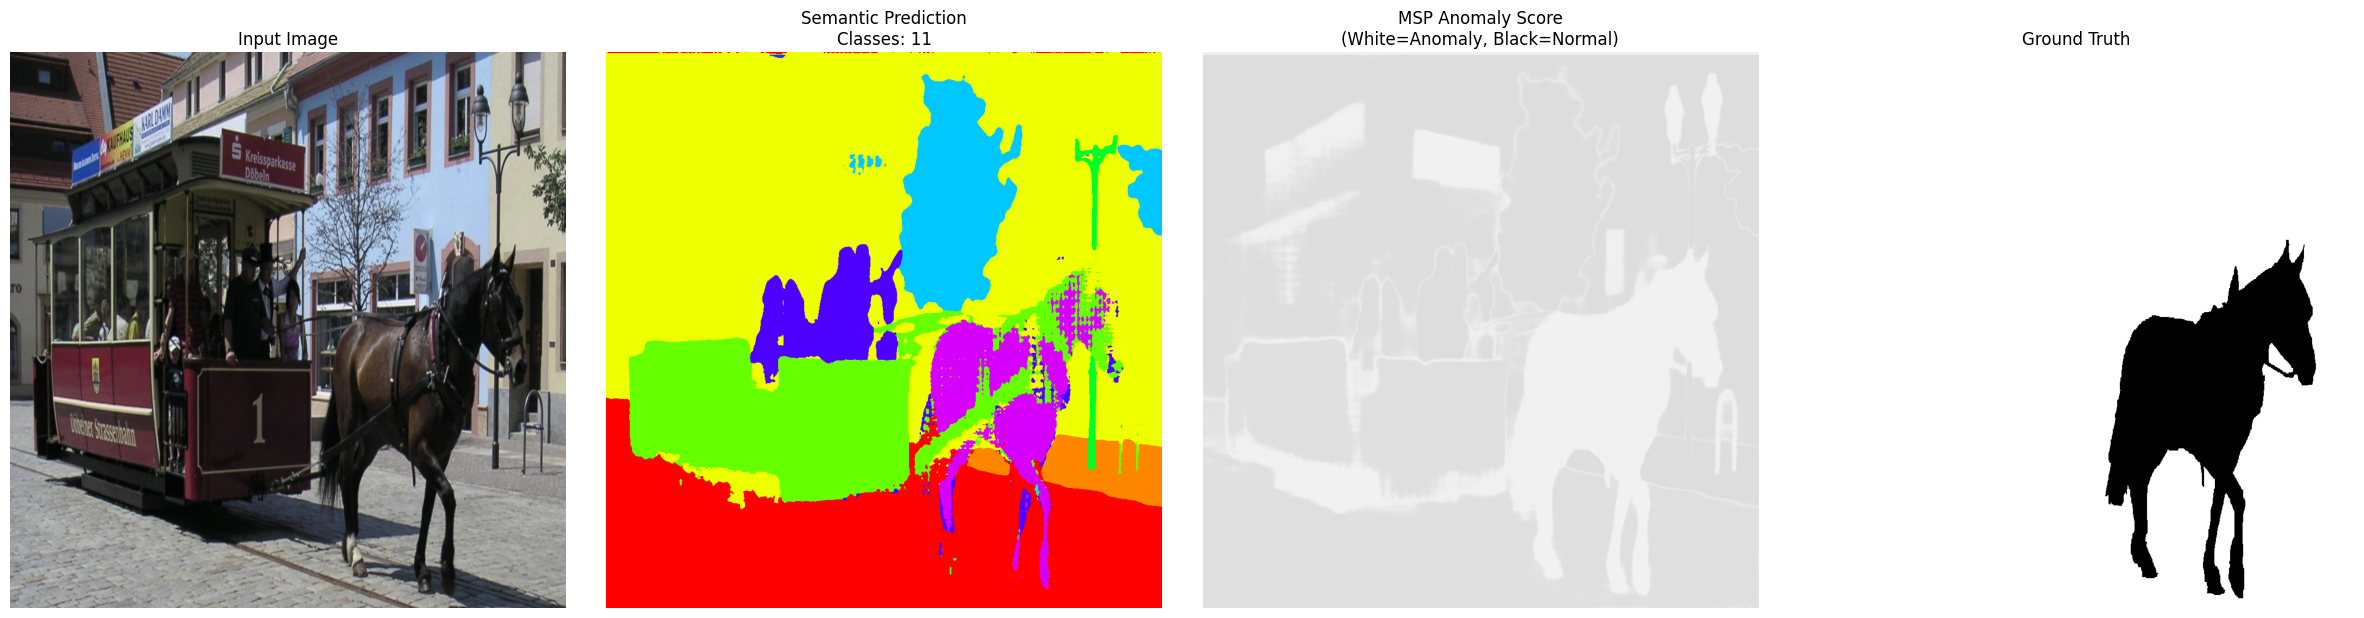

In [12]:
run_inference_and_plot(model, device, datasets_cfg, img_idx=6)

In [13]:
def scale_image(img_):
    if img_.dtype.is_floating_point:
        # Scale 0-1 float to 0-255
        img_ = (img_ * 255).byte() if img_.max() <= 1.0 else img_.byte()

    return img_

In [14]:
def infer_semantic_anomaly_score(
    img,
    target=None,
    *,
    use_image_features: bool = False,
    return_features: bool = False,
    device_ = device):

    """
    Args:
        img: Tensor [C,H,W]
        target: opzionale (Tensor/np/...)
        use_image_features: se True, passa le feature (outputs[2]) a compute_anomaly_score
        return_features: se True, ritorna anche le feature

    Returns:
        Se return_features=False:
            (logits_2chw, anomaly_map_hw, target_array_or_None)
        Se return_features=True:
            (logits_2chw, anomaly_map_hw, target_array_or_None, vis_features_or_None)
    """
    model.eval()

    with torch.no_grad(), torch.autocast(device_type=device_.type, dtype=torch.float16):
        # 1) Windowing richiede uint8
        imgs = [scale_image(img.to(device_))]
        img_sizes = [img.shape[-2:] for img in imgs]

        crops, origins = model.window_imgs_semantic(imgs)
        crops = crops.float() / 255.0

        outputs = model.network(crops)
        mask_logits = outputs[0][-1]
        class_logits = outputs[1][-1]

        vis_features = outputs[2] if (len(outputs) > 2) else None
        features_arg = vis_features if use_image_features else None

        h_crop, w_crop = crops.shape[-2:]
        anomaly_logits_dense = model.network.compute_anomaly_score(
            mask_logits,
            class_logits,
            (h_crop, w_crop),
            features=features_arg,
        )

        anom_logit_permuted = anomaly_logits_dense.permute(0, 3, 1, 2)
        zeros = torch.zeros_like(anom_logit_permuted)
        crop_logits = torch.cat([zeros, anom_logit_permuted], dim=1)

        logits = model.revert_window_logits_semantic(crop_logits, origins, img_sizes)

        full_probs = F.softmax(logits[0], dim=0)
        anomaly_map = full_probs[1].cpu().float().numpy()

    target_array = None
    if target is not None:
        target_tensor = model.to_per_pixel_targets_semantic([target], IGNORE_INDEX)[0]
        target_array = target_tensor.cpu().numpy()

    if return_features:
        return logits[0], anomaly_map, target_array, vis_features
    return logits[0], anomaly_map, target_array

# **Evaluation using anomaly logits**  <br>
This evaluation directly considers anomaly logits score from the Anomaly Head

In [15]:
def plot_semantic_results(
    img,
    pred_map,
    target_array,
    *,
    ignore_index: int = IGNORE_INDEX,
    layout: str = "tight",   # "tight" o "constrained"
    void_value: float | None = 0.5):

    """
    Plots:
      1. Input Image
      2. Anomaly Heatmap (Prediction)
      3. Ground Truth Mask
    """

    img_np = img.permute(1, 2, 0).cpu().float().numpy()
    if img_np.max() > 1.1:
        img_np = img_np / 255.0
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-6)

    use_constrained = (layout == "constrained")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=use_constrained)

    axes[0].imshow(img_np)
    axes[0].set_title("Input Image")

    im1 = axes[1].imshow(pred_map, cmap="jet", vmin=0, vmax=1)
    axes[1].set_title("Anomaly Score (Prob Class 1)")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    target_vis = np.array(target_array, copy=True).astype(float)
    if void_value is None:
        target_vis[target_vis == ignore_index] = 0.0
    else:
        target_vis[target_vis == ignore_index] = float(void_value)

    axes[2].imshow(target_vis, cmap="gray", vmin=0, vmax=1)
    axes[2].set_title("Ground Truth (White=Anomaly)")

    for ax in axes:
        ax.axis("off")

    if not use_constrained:
        fig.tight_layout()
    plt.show()

In [16]:
def eval_one_dataset(
    *,
    dataset_name: str,
    dataloader: torch.utils.data.DataLoader,
    ignore_index: int = IGNORE_INDEX,
    use_image_features: bool = False,
    plot_first: bool = False,
    plot_every: int | None = None) -> list[dict[str, Any]]:

    acc_labels: list[np.ndarray] = []
    acc_scores: list[np.ndarray] = []
    plotted = 0

    for step, (_img, _target) in enumerate(tqdm(dataloader, desc=f"Evaluating {dataset_name:>20s}")):

        if isinstance(_img, torch.Tensor) and _img.dim() == 4:
            _img = _img[0]

        if isinstance(_target, dict):
            _target = {k: (v[0] if isinstance(v, torch.Tensor) else v) for k, v in _target.items()}
        elif isinstance(_target, torch.Tensor) and _target.dim() == 3:
            _target = _target[0]

        logits, anomaly_score, gt = infer_semantic_anomaly_score(
            _img, _target, use_image_features=use_image_features)

        valid = (gt != ignore_index)
        if not np.any(valid):
            continue

        y = (gt[valid] == 1).astype(np.uint8)
        score = anomaly_score[valid].astype(np.float32)

        acc_labels.append(y)
        acc_scores.append(score)

        should_plot = False

        if plot_first and plotted == 0:
            should_plot = True
        if plot_every is not None and plot_every > 0 and (step % plot_every == 0):
            should_plot = True

        if should_plot:
            plot_semantic_results(_img, anomaly_score, gt)
            plotted += 1

    if not len(acc_labels):
        warnings.warn(f"No valid pixels found for dataset `{dataset_name}`")
        return []

    y_true = np.concatenate(acc_labels, axis=0)
    y_scores = np.concatenate(acc_scores, axis=0)

    auprc = round(average_precision_score(y_true, y_scores) * 100., 2)
    fpr95 = round(fpr_at_95_tpr(y_scores, y_true) * 100., 2)

    return [{
        "dataset": dataset_name,
        "method": "SupervisedHead",
        "AuPRC": auprc,
        "FPR95": fpr95
    }]


def run_all_datasets(
    *,
    dataset_cfg: list[dict[str, Any]],
    img_size: tuple[int, int],
    batch_size: int,
    num_workers: int,
    out_csv: str,
    use_image_features: bool = False,
    plot_dataset_indices: set[int] | None = None) -> str:

    all_rows: list[dict[str, Any]] = []

    for i, ds_cfg in enumerate(dataset_cfg):
        ds_name = ds_cfg["name"]

        ds = GenericAnomalyDataset(ds_cfg, img_size=img_size)
        dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, num_workers=num_workers)

        plot_this = (plot_dataset_indices is not None and i in plot_dataset_indices)

        rows = eval_one_dataset(
            dataset_name=ds_name,
            dataloader=dl,
            ignore_index=IGNORE_INDEX,
            use_image_features=use_image_features,
            plot_first=plot_this)

        all_rows.extend(rows)

    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["dataset", "method", "AuPRC", "FPR95"])
        writer.writeheader()
        writer.writerows(all_rows)

    return out_csv

In [17]:
def get_table5_csv(config_path_:str,
                   use_image_features: bool = False,
                   plot_dataset_indices: set[int] | None = None,
                   out_csv: str = "results/table5_anomaly.csv"):
    # Load configuration
    with open(config_path_, "r") as f:
        anomaly_cfg = yaml.safe_load(f)

    # Extract parameters
    datasets_cfg = anomaly_cfg["data"]["init_args"]["datasets"]
    img_size = tuple(anomaly_cfg["data"]["init_args"]["img_size"])
    num_workers = int(anomaly_cfg["data"]["init_args"]["num_workers"])

    # Run Evaluation
    final_csv_path = run_all_datasets(
        dataset_cfg=datasets_cfg,
        img_size=img_size,
        batch_size=1,
        num_workers=num_workers,
        use_image_features=use_image_features,
        plot_dataset_indices=plot_dataset_indices,
        out_csv=out_csv)

    print(f"Evaluation completed. Results saved to: {final_csv_path}")

In [18]:
get_table5_csv(
    anomaly_config_path,
    out_csv="results/table5_anomaly.csv",
    use_image_features=True,
    plot_dataset_indices={1,2,3})

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluating          RoadAnomaly:   0%|          | 0/60 [00:00<?, ?it/s]

AttributeError: 'EoMT_EXT' object has no attribute 'compute_anomaly_score'